In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pylab
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import librosa    
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers
import keras

%matplotlib inline


Using TensorFlow backend.


In [2]:
audio_data = []
labels = []
sampling_rate = []
file_names = []


In [3]:
#samplerate, data = wavfile.read("dataset/dog/1-30344-A.wav")
data, samplerate = librosa.load("dataset/dog/1-30344-A.wav", sr=44000) # Downsample 44.1kHz to 8kHz

print(data.shape)
print(samplerate)


(220000,)
44000


In [4]:
time_sec = (len(data)/samplerate)
step = time_sec/len(data)
print(time_sec)
print(step)
i=0
time_divion=[]
while i<=time_sec-step:
    
    time_divion.append(i)
    i=i+step
# the fourth second step
four_sec_step_number = (4*len(time_divion))/time_sec
print(four_sec_step_number)

5.0
2.2727272727272726e-05
176000.0


In [5]:
classes = []
label_number=0
audio_data = []
labels = []
sampling_rate = []
file_names = []
data = []
noisy_removed=[]
noise=[]
for filepath in glob.iglob('dataset/*'):
    
    #print(filepath[9:])
    
    #print(filepath)
    classes.append(filepath[8:])

print(classes)

for i in classes:
    print("the class = "+i+", the label = "+str(label_number))
    for j in glob.iglob('dataset/'+i+'/*'):
        #samplerate, data = wavfile.read(j)
        y, s = librosa.load(j, sr=44000) # Downsample 44.1kHz to 8kHz
        #reduced_noise = nr.reduce_noise(audio_clip=y, noise_clip=y, verbose=False)
        #print(s)
        #print(j)
        data.append([y,label_number])
        #noise.append(y)
        #labels.append(label_number)
        
    label_number = label_number + 1
print(len(labels))
#print(labels)

['004 - Baby cry', '005 - Clock tick', '006 - Person sneeze', '007 - Helicopter', '008 - Chainsaw', '009 - Rooster', '010 - Fire crackling', 'dog', 'rain', 'sea']
the class = 004 - Baby cry, the label = 0
the class = 005 - Clock tick, the label = 1
the class = 006 - Person sneeze, the label = 2
the class = 007 - Helicopter, the label = 3
the class = 008 - Chainsaw, the label = 4
the class = 009 - Rooster, the label = 5
the class = 010 - Fire crackling, the label = 6
the class = dog, the label = 7
the class = rain, the label = 8
the class = sea, the label = 9
0


In [6]:
import random

random.shuffle(data)
audio_data=[]
labels=[]
for i,j in data:
    audio_data.append(i)
    labels.append(j)
    


In [7]:
print(labels[0])

1


Text(0.5,1,'signal in real time')

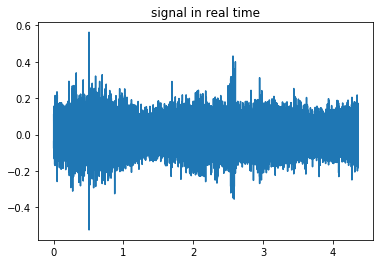

In [8]:
#save_path='dog_time.jpg'
plt.plot(time_divion[0:192000],audio_data[164][0:192000])
#plt.show()
plt.title('signal in real time')
#pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
#pylab.close()


In [9]:
example = random.randint(0,400)
mel_feat = librosa.feature.melspectrogram(y=audio_data[164],sr=44000)
power = librosa.power_to_db(mel_feat,ref=np.max)
print(power.shape)
print(labels[example])

(128, 430)
7


In [10]:
example

113

Text(0.5,1,'Mel Spectrogram')

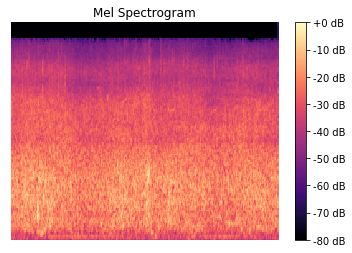

In [11]:

save_path = 'dog.jpg'

plt.axis('off') # no axis
librosa.display.specshow(power)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
#pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
#pylab.close()

In [12]:
power.shape

(128, 430)

In [13]:
melspectrogram = []
for i in range (0,400):
    if i%100 == 0:
        print(i)
    mel_feat = librosa.feature.melspectrogram(y=audio_data[i],sr=44000)
    power = librosa.power_to_db(mel_feat)

    power=power.reshape(-1,1)
  

    melspectrogram.append(power[:54656])
    if power.shape[0]<54656:
        print(i)
        print(power.shape)
    
melspectrogram =np.array(melspectrogram) 
melspectrogram.shape
    

0
100
200
300


(400, 54656, 1)

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
melspectrogram=melspectrogram.reshape(400,-1)
scaler.fit(melspectrogram)
normalized_melspectrogram = scaler.transform(melspectrogram)

print(np.amax(melspectrogram))
print(np.amax(normalized_melspectrogram))



36.726677
1.0000001


In [15]:
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(normalized_melspectrogram, labels, test_size=0.20, random_state=1150)
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.5125


In [17]:
features_convolution = np.reshape(normalized_melspectrogram,(400,128, -1,1))
#melspectrogram=melspectrogram.reshape(400,128, -1)
features_convolution.shape


(400, 128, 427, 1)

In [18]:
y=keras.utils.to_categorical(labels, num_classes=10, dtype='float32')


In [19]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=features_convolution.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#'''
#model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.2))

#'''
#'''
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#'''


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

#model.add(Dense(1000))#input_shape=features.shape[1:]
model.add(Dense(64))#input_shape=features.shape[1:]

model.add(Dense(10))
model.add(Activation('softmax'))
sgd = optimizers.SGD(lr=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
history = model.fit(features_convolution, y,batch_size=8, epochs=30,validation_split=0.2)

Train on 320 samples, validate on 80 samples
Epoch 1/30
320/320 [==============================] - 32s 101ms/step - loss: 2.2985 - acc: 0.2031 - val_loss: 1.7388 - val_acc: 0.3250
Epoch 2/30
320/320 [==============================] - 26s 81ms/step - loss: 1.3187 - acc: 0.5156 - val_loss: 1.5482 - val_acc: 0.4500
Epoch 3/30
320/320 [==============================] - 26s 82ms/step - loss: 0.9481 - acc: 0.6344 - val_loss: 1.1561 - val_acc: 0.5125
Epoch 4/30
320/320 [==============================] - 27s 84ms/step - loss: 0.7318 - acc: 0.7281 - val_loss: 1.0862 - val_acc: 0.5750
Epoch 5/30
320/320 [==============================] - 28s 86ms/step - loss: 0.5510 - acc: 0.7969 - val_loss: 1.0911 - val_acc: 0.6125
Epoch 6/30
320/320 [==============================] - 28s 88ms/step - loss: 0.4617 - acc: 0.8438 - val_loss: 0.9110 - val_acc: 0.6625
Epoch 7/30
320/320 [==============================] - 29s 90ms/step - loss: 0.3902 - acc: 0.8687 - val_loss: 1.0375 - val_acc: 0.6375
Epoch 8/30
320/3

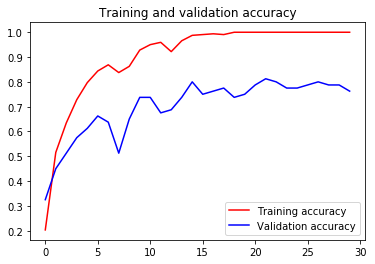

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()